In [8]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data using GMM-like distribution for binary classification
def generate_data(
        n_samples=1000, 
        n_features=5, 
        n_clusters_per_class=2,
        n_informative=5, 
        n_redundant=0
    ):
    X, y = make_classification(n_samples=n_samples, n_features=n_features,
                               n_informative=n_informative, n_redundant=n_redundant,
                               n_clusters_per_class=n_clusters_per_class,
                               random_state=42)
    y = 2 * y - 1  # Convert labels from {0, 1} to {-1, 1}
    return X, y


def generate_ood_data(n_samples=200, n_features=5, n_clusters_per_class=2):
    X_ood, y_ood = make_classification(n_samples=n_samples, n_features=n_features,
                                       n_informative=n_features, n_redundant=0,
                                       shift=0.5, scale=2.0,
                                       n_clusters_per_class=n_clusters_per_class,
                                       random_state=0)
    y_ood = 2 * y_ood - 1  # Convert labels from {0, 1} to {-1, 1}
    return X_ood, y_ood


def train_logistic_regression(X_train, y_train, X_val, y_val):
    model = SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, random_state=42)
    X_train_losses, X_val_losses = [], []
    for _ in range(100):
        model.partial_fit(X_train, y_train, classes=np.unique(y_train))
        X_train_losses.append(-np.log(model.predict_proba(X_train)[
            np.arange(len(y_train)), np.where(y_train<0, 0, 1)] + 1e-10))
        X_val_losses.append(-np.log(model.predict_proba(X_val)[
            np.arange(len(y_val)), np.where(y_val<0, 0, 1)] + 1e-10))
    X_train_losses = np.stack(X_train_losses, axis=1)
    X_val_losses = np.stack(X_val_losses, axis=1)
    
    # Calculate validation accuracy
    val_accuracy = model.score(X_val, y_val)
    
    return model, val_accuracy, X_train_losses, X_val_losses


def compute_gradient(X, y, model):
    prob = model.predict_proba(X)[np.arange(len(y)), np.where(y<0, 0, 1)]
    grad = np.multiply(X, np.expand_dims(np.multiply(y, (1 - prob)), -1))
    # grad = grad / np.linalg.norm(grad, axis=1, keepdims=True)
    return grad


def select_hard_to_learn(X, y, X_train_losses, budget=0.1):
    difficulty_score = 1 + np.exp(X_train_losses).mean(axis=1)
    difficult_indices = np.argsort(difficulty_score)[-int(budget * y.shape[0]):]

    return X[difficult_indices], y[difficult_indices], difficult_indices


def select_non_prototypical_loss(X, y, X_train_losses, n_clusters=10, budget=0.1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    distances = kmeans.fit_transform(X_train_losses).min(axis=1)
    non_prototypical_indices = np.argsort(distances)[-int(budget * y.shape[0]):]

    return X[non_prototypical_indices], y[non_prototypical_indices], non_prototypical_indices


def select_non_prototypical_hidden_state(X, y, n_clusters=10, budget=0.1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    distances = kmeans.fit_transform(X).min(axis=1)
    non_prototypical_indices = np.argsort(distances)[-int(budget * y.shape[0]):]

    return X[non_prototypical_indices], y[non_prototypical_indices], non_prototypical_indices


def select_non_prototypical_grad(X_train, y_train, model, n_clusters=10, budget=0.1):
    X_train_grad = compute_gradient(X_train, y_train, model)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    distances = kmeans.fit_transform(X_train_grad).min(axis=1)
    non_prototypical_indices = np.argsort(distances)[-int(budget * y_train.shape[0]):]

    return X_train[non_prototypical_indices], y_train[non_prototypical_indices], non_prototypical_indices


def select_diverse_loss(X, y, X_train_losses, n_clusters=10, budget=0.1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_train_losses)
    cluster_budget = int(budget * y.shape[0] / n_clusters)

    # Select an equal number of points from each cluster
    kept_indices = []
    for cluster in np.unique(clusters):
        cluster_indices = np.where(clusters == cluster)[0]
        np.random.shuffle(cluster_indices)
        kept_indices.extend(cluster_indices[:cluster_budget])

    return X[kept_indices], y[kept_indices], kept_indices


def select_diverse_hidden_state(X, y, n_clusters=10, budget=0.1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)
    cluster_budget = int(budget * y.shape[0] / n_clusters)

    # Select an equal number of points from each cluster
    kept_indices = []
    for cluster in np.unique(clusters):
        cluster_indices = np.where(clusters == cluster)[0]
        np.random.shuffle(cluster_indices)
        kept_indices.extend(cluster_indices[:cluster_budget])

    return X[kept_indices], y[kept_indices], kept_indices


def select_diverse_grad(X_train, y_train, model, n_clusters=10, budget=0.1):
    train_grad = compute_gradient(X_train, y_train, model)
    clusters = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(train_grad)
    cluster_budget = int(budget * y_train.shape[0] / n_clusters)

    kept_indices = []
    for cluster in np.unique(clusters):
        cluster_indices = np.where(clusters == cluster)[0]
        np.random.shuffle(cluster_indices)
        kept_indices.extend(cluster_indices[:cluster_budget])

    return X_train[kept_indices], y_train[kept_indices], kept_indices


def select_influence_loss(X_train, y_train, X_train_losses, X_val_losses, budget=0.1):
    influence_score = np.dot(X_train_losses, X_val_losses.mean(axis=0, keepdims=True).T)[:, 0]
    influential_indices = np.argsort(influence_score)[-int(budget * y_train.shape[0]):]
    return X_train[influential_indices], y_train[influential_indices], influential_indices


def select_influence_hidden_state(X_train, y_train, X_val, budget=0.1):
    influence_score = np.dot(X_train, X_val.mean(axis=0, keepdims=True).T)[:, 0]
    influential_indices = np.argsort(influence_score)[-int(budget * y_train.shape[0]):]
    return X_train[influential_indices], y_train[influential_indices], influential_indices


def select_influential_grad(X_train, y_train, X_val, y_val, model, budget=0.1):
    train_grad = compute_gradient(X_train, y_train, model)
    val_grad = compute_gradient(X_val, y_val, model)
    num_instances = y_train.shape[0]
    influence_score = np.dot(train_grad, val_grad.mean(axis=0, keepdims=True).T)[:, 0]
    influential_indices = np.argsort(influence_score)[-int(budget * num_instances):]

    return X_train[influential_indices], y_train[influential_indices], influential_indices



ref_val_accuracy: 0.8750


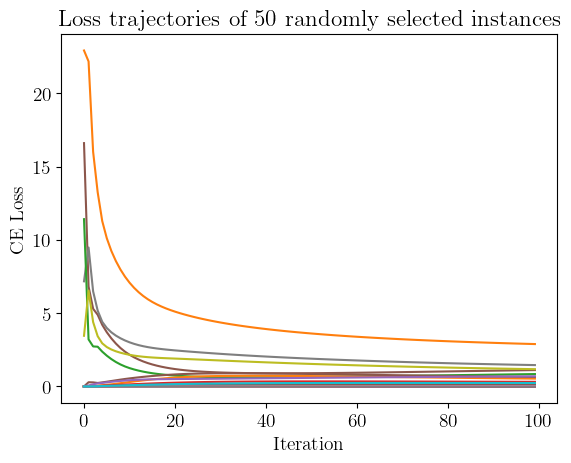

In [9]:
import os

save_dir = '../figures/arr/selection_strategy/'
os.makedirs(save_dir, exist_ok=True)
# Generate in-distribution data
X, y = generate_data(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=2)
X_ood, y_ood = generate_ood_data(n_samples=200, n_features=2, n_clusters_per_class=2)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

ref_model, ref_val_accuracy, X_train_losses, X_val_losses = train_logistic_regression(X_train, y_train, X_val, y_val)
print(f"ref_val_accuracy: {ref_val_accuracy:.4f}")

# randomly select 100 instances and plot their loss trajectories
indices = np.random.choice(X_train_losses.shape[0], 50, replace=False)
for index in indices:
    plt.plot(X_train_losses[index])
plt.title('Loss trajectories of 50 randomly selected instances')
plt.xlabel('Iteration')
plt.ylabel('CE Loss')
plt.show()
plt.close()


In [10]:
budget = 0.3
n_clusters = 2
X_train_hard_to_learn, y_train_hard_to_learn, hard_to_learn_indices = \
    select_hard_to_learn(X_train, y_train, X_train_losses, budget=budget)
X_train_non_prototypical_loss, y_train_non_prototypical_loss, non_prototypical_loss_indices = \
    select_non_prototypical_loss(X_train, y_train, X_train_losses, n_clusters=n_clusters, budget=budget)
X_train_non_prototypical_hidden_state, y_train_non_prototypical_hidden_state, non_prototypical_hidden_state_indices = \
    select_non_prototypical_hidden_state(X_train, y_train, n_clusters=n_clusters, budget=budget)
X_train_non_prototypical_grad, y_train_non_prototypical_grad, non_prototypical_grad_indices = \
    select_non_prototypical_grad(X_train, y_train, ref_model, n_clusters=n_clusters, budget=budget)
X_train_diverse_loss, y_train_diverse_loss, diverse_loss_indices = \
    select_diverse_loss(X_train, y_train, X_train_losses, n_clusters=n_clusters, budget=budget)
X_train_diverse_hidden_state, y_train_diverse_hidden_state, diverse_hidden_state_indices = \
    select_diverse_hidden_state(X_train, y_train, n_clusters=n_clusters, budget=budget)
X_train_diverse_grad, y_train_diverse_grad, diverse_grad_indices = \
    select_diverse_grad(X_train, y_train, ref_model, n_clusters=n_clusters, budget=budget)
X_train_influential_loss, y_train_influential_loss, influential_loss_indices = \
    select_influence_loss(X_train, y_train, X_train_losses, X_val_losses, budget=budget)
X_train_influential_loss_ood, y_train_influential_loss_ood, influential_loss_indices_ood = \
    select_influence_loss(X_train, y_train, X_train_losses, X_val_losses, budget=budget)
X_train_influential_hidden_state, y_train_influential_hidden_state, influential_hidden_state_indices = \
    select_influence_hidden_state(X_train, y_train, X_val, budget=budget)
X_train_influential_hidden_state_ood, y_train_influential_hidden_state_ood, influential_hidden_state_indices_ood = \
    select_influence_hidden_state(X_train, y_train, X_ood, budget=budget)
X_train_influential_grad, y_train_influential_grad, influential_grad_indices = \
    select_influential_grad(X_train, y_train, X_val, y_val, ref_model, budget=budget)
X_train_influential_grad_ood, y_train_influential_grad_ood, influential_grad_indices_ood = \
    select_influential_grad(X_train, y_train, X_ood, y_ood, ref_model, budget=budget)

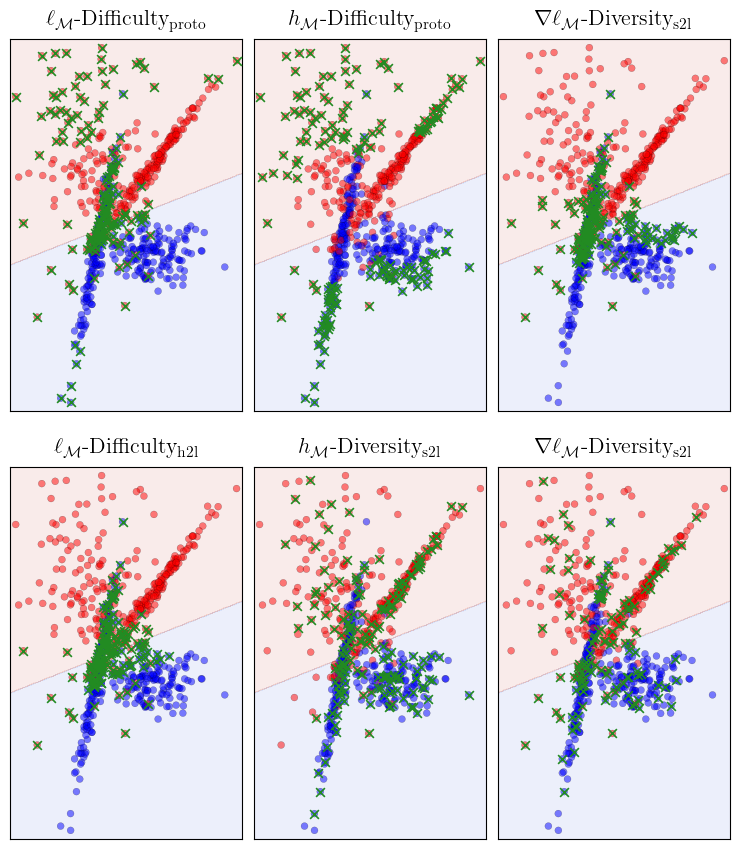

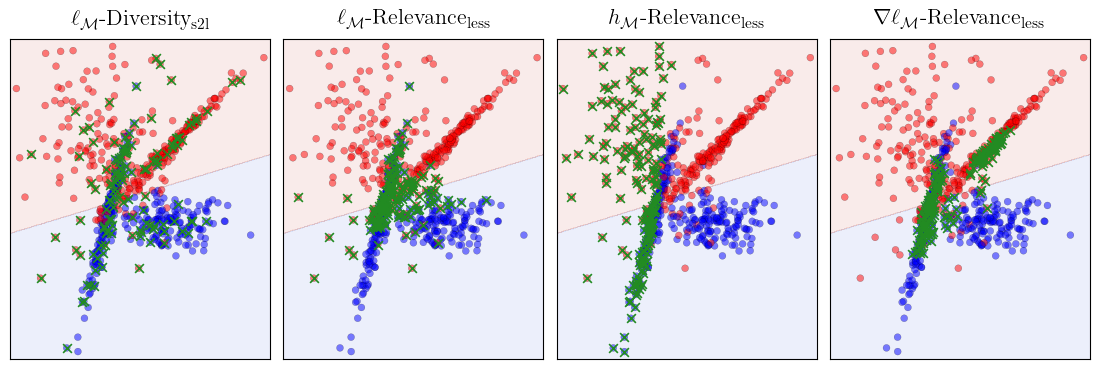

In [11]:
from matplotlib import rc
import os
import numpy as np
import matplotlib.pyplot as plt

# Enable LaTeX font rendering and increase font size
rc('text', usetex=True)
rc('font', family='serif', size=14)

# Function to plot decision boundary
def plot_decision_boundary(ax, model, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Softer decision boundary
    ax.contourf(xx, yy, Z, alpha=0.1, cmap='coolwarm')  
    
    # Scatter plot for data points with lighter red and blue
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.5, s=25, edgecolor='k', linewidth=0.2, zorder=1)

# Shared marker style for selected instances
marker_style = dict(c='forestgreen', marker='x', s=40, linewidths=1.2, zorder=3)

# Group names, indices, LaTeX titles, and columns per group
group_dict = {
    'main': {
        'data': [
            (non_prototypical_loss_indices, r'$\ell_{\mathcal{M}}$-Difficulty$_{\mathrm{proto}}$'),
            (non_prototypical_hidden_state_indices, r'$h_{\mathcal{M}}$-Difficulty$_{\mathrm{proto}}$'),
            (non_prototypical_grad_indices, r'$\nabla \ell_{\mathcal{M}}$-Diversity$_{\mathrm{s2l}}$'),
            (hard_to_learn_indices, r'$\ell_{\mathcal{M}}$-Difficulty$_{\mathrm{h2l}}$'),
            (diverse_hidden_state_indices, r'$h_{\mathcal{M}}$-Diversity$_{\mathrm{s2l}}$'),
            (diverse_grad_indices, r'$\nabla \ell_{\mathcal{M}}$-Diversity$_{\mathrm{s2l}}$'),
        ],
        'n_cols': 3,  # Specify number of columns
        'figsize': (8, 10)  # Narrow figure for vertical orientation
    },
    'appendix': {
        'data': [
            (diverse_loss_indices, r'$\ell_{\mathcal{M}}$-Diversity$_{\mathrm{s2l}}$'),
            (influential_loss_indices, r'$\ell_{\mathcal{M}}$-Relevance$_{\mathrm{less}}$'),
            (influential_hidden_state_indices, r'$h_{\mathcal{M}}$-Relevance$_{\mathrm{less}}$'),
            (influential_grad_indices, r'$\nabla \ell_{\mathcal{M}}$-Relevance$_{\mathrm{less}}$'),
        ],
        'n_cols': 4,  # Specify number of columns
        'figsize': (12, 4)  # Wider figure for horizontal layout
    }
}

for group_name, group_config in group_dict.items():
    group = group_config['data']
    n_cols = group_config['n_cols']
    figsize = group_config['figsize']
    n_plots = len(group)
    n_rows = (n_plots + n_cols - 1) // n_cols  # Ensure correct number of rows for the subplots

    # Plot setup
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize, 
                             gridspec_kw={'wspace': 0.05, 'hspace': 0.15 if group_name == 'main' else 0.05})

    # Flatten axes array for easier indexing
    axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

    for idx, (group_indices, title) in enumerate(group):
        ax = axes[idx]
        
        # Plot decision boundary and data points
        plot_decision_boundary(ax, ref_model, X_train, y_train)
        
        # Add selected markers for the group
        ax.scatter(X_train[group_indices, 0], X_train[group_indices, 1], **marker_style)
        
        # Set subplot title with LaTeX
        ax.set_title(title, fontsize=16, pad=10)  # Added padding for extra spacing

        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim([X_train[:, 0].min() - 0.2, X_train[:, 0].max() + 0.2])
        ax.set_ylim([X_train[:, 1].min() - 0.2, X_train[:, 1].max() + 0.2])

    # Hide unused subplots
    for idx in range(len(group), len(axes)):
        axes[idx].axis('off')

    # Save and display with tight bounding box
    plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.05, hspace=0.15 if group_name == 'main' else 0.05)
    plt.savefig(os.path.join(save_dir, f'{group_name}.pdf'), bbox_inches='tight')
    plt.show()
    plt.close(fig)
